* The notebook is developed to code the methodology and extract relevant files that are suitable as input to PEST.
- pestpp/pestpp/benchmarks/mf6_freyberg - This is used as the standard benchmark folder from which the files are referred.
- Currently, the freyberg6_run_glm.pst which solves the Levenberg - Marquardt algorithm is considered.

Parameters considered: 'alpha_p_gp', 'alpha_m_gp', 'n_p_gp', 'n_m_gp', 'wr_p_gp', 'wr_m_gp', 'tcs_p_gp', 'tcs_m_gp', 'tcd_p_gp', 'tcd_m_gp', 'af_p_gp', 'af_m_gp', 'auf_p_gp', 'auf_m_gp', 'por_p_gp', 'por_m_gp', 'perm_p_gp', 'perm_m_gp', 'den_p_gp', 'den_m_gp','hc_l','hc_r','lh_w','lh_i'

- We are considering the initial parameters based on the simulation : all_params_afterrw.demo

- The lower and upper bound is fixed to 50 % of the initial value

- Some values that do not accept these changes, have been changed with respect to their initial value


TODO:
- Template files
- Instruction files
- Output files from ATS (observation.dat) - How to hint PEST about these instruction files?
- Input file (input.xml) how do we change the parameter here as per the template file?

* Develop a methodology and write here!



In [126]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [127]:
%matplotlib inline
import sys,os
import colors
import numpy as np
import matplotlib.cm
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import pandas as pd
from datetime import datetime
import matplotlib.image as mpimg

In [133]:
import shutil
import numpy as np
import pandas as pd
import pyemu
import flopy
import subprocess

In [129]:
directory_name = 'all_params_lubnd.demo'

### Observation - data

In [130]:
filename_measurements = 'AWS_Yakou_ITP_Data_2015-20.xlsx'

### Processing data

In [109]:
df_AWS = pd.read_excel(f'{filename_measurements}',index_col=0,parse_dates=True)

In [131]:
# Dropping an unnecessary column:
df_AWS.drop(['Unnamed: 34'], axis=1,inplace=True)

In [132]:
df_AWS_details = pd.read_excel('Available_data.xlsx', sheet_name='AWS_Yakou_ITP_Data_2019_extract',index_col=0,parse_dates=True)  
df_AWS_details.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Available_data.xlsx'

In [14]:
df_AWS_details['Parameter']

Sl.No.
1                   Wind speed at 10 m (m/s)
2                 Wind direction at 10 m (°)
3                Air temperature at 5 m (°C)
4               Relative humidity at 5 m (%)
5                 Precipitation at 10 m (mm)
6                         Air pressure (hPa)
7                  Infrared temperature (°C)
8                  Infrared temperature (°C)
9                                   PAR_down
10                                    PAR_up
11      Incoming shortwave radiation (W/m^2)
12      Outgoing shortwave radiation (W/m^2)
13       Incoming longwave radiation (W/m^2)
14       Outgoing longwave radiation (W/m^2)
15                     Net radiation (W/m^2)
16    Soil heat flux at - 0.06 m (W/m^2) - 1
17    Soil heat flux at - 0.06 m (W/m^2) - 2
18    Soil heat flux at - 0.06 m (W/m^2) - 3
19             Soil moisture at - 0.04 m (%)
20              Soil moisture at - 0.1 m (%)
21              Soil moisture at - 0.2 m (%)
22              Soil moisture at - 0.4 m (%)
23 

In [15]:
### Renaming the columns - 
data_AWS = df_AWS.copy()
data_AWS.columns = df_AWS_details['Parameter'].values
data_AWS.columns

Index(['Wind speed at 10 m (m/s)', 'Wind direction at 10 m (°)',
       'Air temperature at 5 m (°C)', 'Relative humidity at 5 m (%)',
       'Precipitation at 10 m (mm)', 'Air pressure (hPa)',
       'Infrared temperature (°C)', 'Infrared temperature (°C)', 'PAR_down',
       'PAR_up', 'Incoming shortwave radiation (W/m^2)',
       'Outgoing shortwave radiation (W/m^2)',
       'Incoming longwave radiation (W/m^2)',
       'Outgoing longwave radiation (W/m^2)', 'Net radiation (W/m^2)',
       'Soil heat flux at - 0.06 m (W/m^2) - 1',
       'Soil heat flux at - 0.06 m (W/m^2) - 2',
       'Soil heat flux at - 0.06 m (W/m^2) - 3',
       'Soil moisture at - 0.04 m (%)', 'Soil moisture at - 0.1 m (%)',
       'Soil moisture at - 0.2 m (%)', 'Soil moisture at - 0.4 m (%)',
       'Soil moisture at - 0.8 m (%)', 'Soil moisture at - 1.2 m (%)',
       'Soil moisture at - 1.6 m (%)', 'Soil temperature at - 0.00 m (°C)',
       'Soil temperature at - 0.04 m (°C)', 'Soil temperature at - 0.1 

### The data has -6999 values for missing data
- Therefore replacing -6999 with NaN vaues

In [16]:
data_AWS_syn = data_AWS.copy()
data_AWS_syn = data_AWS_syn.replace(-6999,None)

In [17]:
data_AWS_prep = data_AWS_syn.copy()

In [18]:
len(data_AWS_syn.index[np.where(np.isnan(data_AWS_syn))[0]])

40078

In [19]:
len(data_AWS_syn['Wind speed at 10 m (m/s)']), len(data_AWS_syn.columns), len(data_AWS_syn['Wind speed at 10 m (m/s)'])*len(data_AWS_syn.columns)

(278132, 33, 9178356)

### Comments:
- Few NaN values are present (278132/9178356 = 3.03% ). Since the data is available every 10 mins, we have considered to resample the data. 
- Find the number of NaN values in each column to identify where they are occuring and then decide weather to consider the data or not? - Try later

### Resampling the data to daily mean values 
* To observe the data on a seasonal scale

In [20]:
data_AWS_syn = data_AWS_syn.resample('D').mean()

#### Precipitation - Daily summation of the values are determined instead of mean

In [21]:
data_AWS_prep_dailysum = data_AWS_prep['Precipitation at 10 m (mm)'].resample('D').sum()

### Reducing the data to the year 2017

In [22]:
data_AWS_syn_2017 = data_AWS_syn.loc['2017']

# Changing the units of temperature to Kelvin

depths = [0.04, 0.1, 0.2, 0.4, 0.8, 1.2, 1.6]

for i, depth in enumerate(depths):
    data_AWS_syn_2017[f'Soil temperature at - {depth} m (K)'] = data_AWS_syn_2017[f'Soil temperature at - {depth} m (°C)'] + 273.15
    

How do you convert the data to be PEST suitable?

In [23]:
data_AWS_syn_2017['Soil moisture at - 0.1 m (%)'].describe()

count    365.000000
mean      21.170168
std       14.097898
min        7.838556
25%        8.612361
50%       11.120139
75%       36.488264
max       46.251181
Name: Soil moisture at - 0.1 m (%), dtype: float64

#### Accessing data - from simulations:

In [26]:
sim_data = pd.read_csv('rk_model_glm_obs_data.dat', sep=' ')
sim_data['point -0.04 saturation liquid'].describe()

count    366.000000
mean       0.298824
std        0.273229
min        0.106138
25%        0.107801
50%        0.110564
75%        0.703625
max        0.713422
Name: point -0.04 saturation liquid, dtype: float64

<AxesSubplot:>

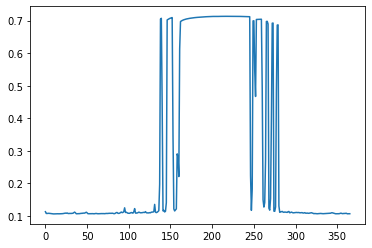

In [27]:
sim_data['point -0.04 saturation liquid'].plot()

### Changing VWC (Volumetric water content) [measured data] to saturation of liquid [simulated data]
\begin{equation}
    VWC = \frac{V_w}{V_T}
\end{equation}
where, $V_w$ - Volume of water, $V_T$ - Total volume = $V_s + V_w + V_a$ 

\begin{equation}
    s_l = \frac{V_w}{V_T}
\end{equation}

##### We are not doing this! - since we will converting the outputs to VWC data


In [28]:
# Need to change VWC to saturation of liquid [Which is the output]
# Coverting saturation to VWC [Liquid]: Saturation = VWC / (porosity * 100)

#porosity_peat = 0.5 # Peat layer until 0.385
#porosity_mineral = 0.3 # Mineral layer until 2.24 m
#depths = [0.04, 0.1, 0.2, 0.4, 0.8, 1.2, 1.6]

#for i, depth in enumerate(depths):
    #if depth < 0.385:
        #data_AWS_syn_2017[f'point - {depth} m saturation liquid'] = data_AWS_syn_2017[f'Soil moisture at - {depth} m (%)']/(porosity_peat*100)
    #else:
        #data_AWS_syn_2017[f'point - {depth} m saturation liquid'] = data_AWS_syn_2017[f'Soil moisture at - {depth} m (%)']/(porosity_mineral*100)

### 1. Parameter groups external
- Extracting the data from the example

In [110]:
pargrp_data_example = pd.read_csv('Freyberg_example/freyberg6_run_glm.pargrp_data.csv') 
pargrp_data_example.head()

,pargpnme,inctyp,derinc,derinclb,forcen,derincmul,dermthd,splitthresh,splitreldiff,splitaction
0,sto_ss_0,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller
1,npf_k33_1,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller
2,npf_k_1,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller
3,sto_ss_1,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller
4,npf_k_0,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller


In [111]:
pargrp_data_example.dtypes

pargpnme         object
inctyp           object
derinc          float64
derinclb        float64
forcen           object
derincmul       float64
dermthd          object
splitthresh     float64
splitreldiff    float64
splitaction      object
dtype: object

#### Defining the variables in Parameter Group variables: 
- PARGPNME : Individual groups assigned for all parameters! - Assigned a total of 20 parameters (10 for each material)
- INCTYP : 'relative' - The increment used for forward-difference calculation of derivatives with respect to any parameter belonging to the group is calculated as the fraction of the current value of that parameter; that fraction is provided as the real variable DERINC. Ex: If current value of parameter = 10 & DERINC =  0.01. Then the next parameter value = 0.01 * 10 = 0.1.
- DERINC : '0.01' - The fraction of increment of the current value of parameter. [Consider the range of variation of the parameters, upper and lower bounds]
- DERINCLB : '0.0'
- FORCEN : 'switch'. In the first iteration, forward difference method is employed. From the second iteration, it switches to central difference method for the remainder of the inversion process on the iteration after which the relative objective function reduction between successive iterations is less than PHIREDSWH. Note we need to define PHIREDSWH (Where is it defined in this format?)
- DERINCMUL : '1.0' - If three-point derivatives calculation is employed, the value of DERINC is multiplied by DERINCMUL.
- DERMTHD : 'parabolic' - This is preferred as it provides greater accuracy.
- [SPLITTHRESH] [SPLITRELDIFF] [SPLITACTION] - For the first analysis, we ignore the three variables.

In [112]:
pargrp = pargrp_data_example.copy()
# Dropping all rows to replace with the two newly defined rows
pargrp.drop(pargrp.index, inplace=True)
# Dropping the columns - splitthresh, splitreldiff, splitaction
pargrp.drop(columns=['splitthresh', 'splitreldiff', 'splitaction'], inplace=True)

group_names = ['alpha_p_gp', 'alpha_m_gp', 'n_p_gp', 'n_m_gp', 'wr_p_gp', 'wr_m_gp', 'tcs_p_gp', 'tcs_m_gp', 'tcd_p_gp', 'tcd_m_gp', 'af_p_gp', 'af_m_gp', 'auf_p_gp', 'auf_m_gp', 'por_p_gp', 'por_m_gp', 'perm_p_gp', 'perm_m_gp', 'den_p_gp', 'den_m_gp','hc_l_gp','hc_r_gp','lh_w_gp','lh_i_gp']

for i, gp_nm in enumerate(group_names):
    pargrp.loc[i] = [gp_nm, 'relative',0.1,0.0,'switch',1.0,'parabolic']
    #print(i, gp_nm)
    
pargrp

,pargpnme,inctyp,derinc,derinclb,forcen,derincmul,dermthd
0,alpha_p_gp,relative,0.1,0.0,switch,1.0,parabolic
1,alpha_m_gp,relative,0.1,0.0,switch,1.0,parabolic
2,n_p_gp,relative,0.1,0.0,switch,1.0,parabolic
3,n_m_gp,relative,0.1,0.0,switch,1.0,parabolic
4,wr_p_gp,relative,0.1,0.0,switch,1.0,parabolic
5,wr_m_gp,relative,0.1,0.0,switch,1.0,parabolic
6,tcs_p_gp,relative,0.1,0.0,switch,1.0,parabolic
7,tcs_m_gp,relative,0.1,0.0,switch,1.0,parabolic
8,tcd_p_gp,relative,0.1,0.0,switch,1.0,parabolic
9,tcd_m_gp,relative,0.1,0.0,switch,1.0,parabolic


In [113]:
pargrp.dtypes

pargpnme      object
inctyp        object
derinc       float64
derinclb     float64
forcen        object
derincmul    float64
dermthd       object
dtype: object

In [114]:
directory_name

'all_params_lubnd.demo'

In [115]:
# Exporting the parameter group csv file
pargrp.to_csv(f'{directory_name}/rk_model_glm_pargrp_data.csv', index=False)

### 1. Parameter names external
There are 24 parameters that we are considering for this first analysis

In [116]:
par_data_example = pd.read_csv('Freyberg_example/freyberg6_run_glm.par_data.csv') 
par_data_example

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,partied
0,npf_k33_0_000_000,log,factor,0.300000,0.030000,3.000000,npf_k33_0,1.0,0.0,1,NaN
1,npf_k33_0_000_001,tied,factor,0.300000,0.030000,3.000000,npf_k33_0,1.0,0.0,1,npf_k33_0_000_000
2,npf_k33_0_000_002,tied,factor,0.300000,0.030000,3.000000,npf_k33_0,1.0,0.0,1,npf_k33_0_000_000
3,npf_k33_0_000_003,tied,factor,0.300000,0.030000,3.000000,npf_k33_0,1.0,0.0,1,npf_k33_0_000_000
4,npf_k33_0_000_004,tied,factor,0.300000,0.030000,3.000000,npf_k33_0,1.0,0.0,1,npf_k33_0_000_000
...,...,...,...,...,...,...,...,...,...,...,...
8170,welflx_2_9_16_5,tied,factor,202.364469,56.212353,393.486468,welflux_5,-1.0,0.0,1,welflx_2_11_13_5
8171,welflx_2_9_16_6,tied,factor,243.645615,67.679338,473.755363,welflux_6,-1.0,0.0,1,welflx_2_11_13_6
8172,welflx_2_9_16_7,tied,factor,262.442880,72.900800,510.305600,welflux_7,-1.0,0.0,1,welflx_2_11_13_7
8173,welflx_2_9_16_8,tied,factor,259.844454,72.179015,505.253105,welflux_8,-1.0,0.0,1,welflx_2_11_13_8


The following details need to be defined:
- PARNME: 'n_m', 'tcs_m', 'af_m', 'af_p', .... - It is the parameter name
- PARTRANS: 'none' {'log' - Can we considered later if the inversion process does not occur. Log-transformations helps in ensuring that the parameter changes and model output changes are more linear.}
- PARCHGLIM: 'factor' - Alteration to a parameter's value is factor-limited. { PARCHGLIM must be provided with a value of “relative” or “factor”. The former designates that alterations to a parameter’s value are factor-limited whereas the latter designates that alterations to its value are relative-limited. }
- PARVALI: 1.2, 1, 0.05, 0.005 - These are the starting values for the parameters
- PARLBND: 1.05, 0.8, 0.02, 0.002 - Lower bounds for the parameters.
- PARUBND: 3, 2.5, 0.1, 0.01 - Upper bounds for the parameters.
- PARGRP: 'hydraulic','thermal','hydraulic', 'hydraulic' - It is the parameter group names associated with the parameters. 
- SCALE: 1.0, 1.0, 1.0, 1.0 - No scale or offset is provided
- OFFSET: 0.0, 0.0, 0.0, 0.0 - No scale or offset is provided
- DERCOM: 1, 1, 1, 1 - Only model command exists. Hence we give 1 which represents 'ats'
- Partied: This column will be dropped since we have no tied elements

In [117]:
# Getting the best parameter dataset from the simulation - all_params_afterrw.demo
directory_name_params = 'all_params_afterrw.demo'
best_params_afterrw = pd.read_csv(f'{directory_name_params}/rk_model_glm_cf_v1_allparams_rw.par',delimiter='\s+',skiprows=1, header=None)
best_params_afterrw.drop(columns=[2,3],inplace=True)
best_params_afterrw.columns = ['parameter','PARVAL1']
best_params_afterrw.head()

# Adding four other parameters - latent heat - water and ice, and heat capacity - liquid and rock
#df_new =  pd.DataFrame({'lh_w':'334000','lh_i':'6007.87','hc_l':'76','hc_r':'620'})

length_index = len(best_params_afterrw.index)

best_params_afterrw.loc[length_index] = ['lh_w','334000']
best_params_afterrw.loc[length_index+1] = ['lh_i','-6007.87']
best_params_afterrw.loc[length_index+2] = ['hc_l','76']
best_params_afterrw.loc[length_index+3] = ['hc_r','620']

best_params_afterrw.index = best_params_afterrw['parameter']
best_params_afterrw.drop(columns='parameter',inplace=True)


# Changing the initial value of n_p, n_m and den_m
best_params_afterrw.loc['n_p'] = 2.05 # Since value below 1.05 is not allowed
best_params_afterrw.loc['n_m'] = 2.05 # Since value below 1.05 is not allowed
best_params_afterrw.loc['den_m'] = 1900 # Since value above 2700 represents a soil mineral layer

#best_params_afterrw.loc['perm_p'] = 5.346622127220000e-11

# Changing to float type 
best_params_afterrw = best_params_afterrw.astype('float64')

# Adding the lower and upper bound - 50%
best_params_afterrw['PARLBND'] = best_params_afterrw['PARVAL1']*0.5
best_params_afterrw['PARUBND'] = best_params_afterrw['PARVAL1']*1.5

best_params_afterrw

,PARVAL1,PARLBND,PARUBND
parameter,,,
alpha_p,1.000000e-02,5.000000e-03,1.500000e-02
alpha_m,1.824914e-03,9.124572e-04,2.737372e-03
n_p,2.050000e+00,1.025000e+00,3.075000e+00
n_m,2.050000e+00,1.025000e+00,3.075000e+00
wr_p,2.243241e-01,1.121621e-01,3.364862e-01
wr_m,1.594881e-01,7.974403e-02,2.392321e-01
tcs_p,4.395766e-01,2.197883e-01,6.593649e-01
tcs_m,9.521051e-01,4.760525e-01,1.428158e+00
tcd_p,1.010234e-01,5.051170e-02,1.515351e-01


In [118]:
pargrp['pargpnme'].values[0]

'alpha_p_gp'

In [119]:
par_data = par_data_example.copy()
par_data.drop(par_data.index, inplace=True)
# Dropping the columns - splitthresh, splitreldiff, splitaction
par_data.drop(columns=['partied'], inplace=True)

#param_names = ['alpha_p', 'alpha_m', 'n_p', 'n_m', 'wr_p', 'wr_m', 'tcs_p', 'tcs_m', 'tcd_p', 'tcd_m', 'af_p', 'af_m', 'auf_p', 'por_p', 'por_m', 'perm_p', 'perm_m', 'den_p', 'den_m', 'lh_w','lh_i','hc_l','hc_r']

for i, values in enumerate(best_params_afterrw.index):
    par_data.loc[i] = [best_params_afterrw.index[i], 'none','factor', best_params_afterrw['PARVAL1'].values[i], best_params_afterrw['PARLBND'].values[i], best_params_afterrw['PARUBND'].values[i], pargrp['pargpnme'].values[i], 1.0, 0.0, 1] 

par_data
# Adding row information:
#par_data.loc[0] = ['alpha_p','none','factor', 0.05, 0.01, 0.1, 'alpha_p_gp', 1.0, 0.0, 1]
#par_data.loc[1] = ['alpha_m','none','factor', 0.005, 0.001, 0.01, 'alpha_m_gp', 1.0, 0.0, 1]

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
0,alpha_p,none,factor,1.000000e-02,5.000000e-03,1.500000e-02,alpha_p_gp,1.0,0.0,1
1,alpha_m,none,factor,1.824914e-03,9.124572e-04,2.737372e-03,alpha_m_gp,1.0,0.0,1
2,n_p,none,factor,2.050000e+00,1.025000e+00,3.075000e+00,n_p_gp,1.0,0.0,1
3,n_m,none,factor,2.050000e+00,1.025000e+00,3.075000e+00,n_m_gp,1.0,0.0,1
4,wr_p,none,factor,2.243241e-01,1.121621e-01,3.364862e-01,wr_p_gp,1.0,0.0,1
5,wr_m,none,factor,1.594881e-01,7.974403e-02,2.392321e-01,wr_m_gp,1.0,0.0,1
6,tcs_p,none,factor,4.395766e-01,2.197883e-01,6.593649e-01,tcs_p_gp,1.0,0.0,1
7,tcs_m,none,factor,9.521051e-01,4.760525e-01,1.428158e+00,tcs_m_gp,1.0,0.0,1
8,tcd_p,none,factor,1.010234e-01,5.051170e-02,1.515351e-01,tcd_p_gp,1.0,0.0,1
9,tcd_m,none,factor,9.844054e-01,4.922027e-01,1.476608e+00,tcd_m_gp,1.0,0.0,1


In [120]:
# Exporting the parameter group csv file
par_data.to_csv(f'{directory_name}/rk_model_glm_par_data.csv', index=False)

### 3. Observation data

In [39]:
obs_data_example = pd.read_csv('Freyberg_example/freyberg6_run_glm.obs_data.csv') 
obs_data_example

,obsnme,obsval,weight,obgnme
0,gage_1_20151231,951.710,0.000000,gage
1,gage_1_20160131,1530.100,0.004357,gage
2,gage_1_20160229,1855.300,0.003593,gage
3,gage_1_20160331,1907.100,0.003496,gage
4,gage_1_20160430,1747.700,0.003815,gage
...,...,...,...,...
1020,trgw_2_9_1_20170831,34.864,0.000000,trgw_2_9_1
1021,trgw_2_9_1_20170930,34.780,0.000000,trgw_2_9_1
1022,trgw_2_9_1_20171031,34.771,0.000000,trgw_2_9_1
1023,trgw_2_9_1_20171130,34.875,0.000000,trgw_2_9_1


The following details need to be defined:

Note: Here we need to add the values from the excel that we read previously.

- OBSNME: stemp_{depth}_{1-365} & smois_{depth}_{1-365}: Observation names - We have temperature and moisture values at 7 depths. 
- OBSVAL: The corresponding values need to be added in pandas from the dataframe - data_AWS_syn_2017
- WEIGHT (Initial): Assigning equal weights to all variables. 1/5110 = 1.9569 10e-4; 2 {soil_temp, soil_mois} * 7 {7 sensors} * 365 {1-365}  = 5110 
- obgnme: 'temp', 'mois'


In [41]:
len(np.arange(0,5110,1))

5110

In [42]:
depth = 0.1
times = 1
data_AWS_syn_2017[f'Soil moisture at - 0.1 m (%)'][times - 1]

8.3525

In [43]:
data_AWS_syn_2017.columns

Index(['Wind speed at 10 m (m/s)', 'Wind direction at 10 m (°)',
       'Air temperature at 5 m (°C)', 'Relative humidity at 5 m (%)',
       'Precipitation at 10 m (mm)', 'Air pressure (hPa)',
       'Infrared temperature (°C)', 'Infrared temperature (°C)', 'PAR_down',
       'PAR_up', 'Incoming shortwave radiation (W/m^2)',
       'Outgoing shortwave radiation (W/m^2)',
       'Incoming longwave radiation (W/m^2)',
       'Outgoing longwave radiation (W/m^2)', 'Net radiation (W/m^2)',
       'Soil heat flux at - 0.06 m (W/m^2) - 1',
       'Soil heat flux at - 0.06 m (W/m^2) - 2',
       'Soil heat flux at - 0.06 m (W/m^2) - 3',
       'Soil moisture at - 0.04 m (%)', 'Soil moisture at - 0.1 m (%)',
       'Soil moisture at - 0.2 m (%)', 'Soil moisture at - 0.4 m (%)',
       'Soil moisture at - 0.8 m (%)', 'Soil moisture at - 1.2 m (%)',
       'Soil moisture at - 1.6 m (%)', 'Soil temperature at - 0.00 m (°C)',
       'Soil temperature at - 0.04 m (°C)', 'Soil temperature at - 0.1 

In [44]:
# Creating a new dataframes with columns = obs_data_example.index and rows = 0 - 5110
# There are 365 values for one sensor in each year, hence we move from 0 - 364 & then it repeats again for the next sensor.

obs_data = pd.DataFrame(data=None,columns=obs_data_example.columns,index=np.arange(1,5111,1))


depths = [0.04, 0.1, 0.2, 0.4, 0.8, 1.2, 1.6]

times = np.arange(1, 366, 1)

# Adding column information:


x = 0
for i, depth in enumerate(depths):
    for j, time in enumerate(times):
        # Column name = obsnme
        obs_data.iloc[x,0] = f'stemp_{depth}_{j}'
        # Column name = obsval
        obs_data.iloc[x,1] = data_AWS_syn_2017[f'Soil temperature at - {depth} m (K)'][j]
        # Column name = weights : Assigning equal weight to all variables
        obs_data.iloc[x,2] = 1/5110
        # Column name = obgnme : Assigning observation group name
        obs_data.iloc[x,3] = 'temp'
        x = x + 1

for i, depth in enumerate(depths):
    for j, time in enumerate(times):
        obs_data.iloc[x,0] = f'smois_{depth}_{j}'
        # Column name = obsval
        obs_data.iloc[x,1] = data_AWS_syn_2017[f'Soil moisture at - {depth} m (%)'][j]
        # Column name = weights : Assigning equal weight to all variables
        obs_data.iloc[x,2] = 1/5110
        # Column name = obgnme : Assigning observation group name
        obs_data.iloc[x,3] = 'mois'
        x = x + 1

        
obs_data

,obsnme,obsval,weight,obgnme
1,stemp_0.04_0,261.023264,0.000196,temp
2,stemp_0.04_1,261.006667,0.000196,temp
3,stemp_0.04_2,260.854861,0.000196,temp
4,stemp_0.04_3,261.032708,0.000196,temp
5,stemp_0.04_4,261.347014,0.000196,temp
...,...,...,...,...
5106,smois_1.6_360,5.058347,0.000196,mois
5107,smois_1.6_361,5.028583,0.000196,mois
5108,smois_1.6_362,5.004326,0.000196,mois
5109,smois_1.6_363,4.981813,0.000196,mois


In [45]:
# Test - observation data in PEST 
obs_data.iloc[1000]

obsnme    stemp_0.2_270
obsval       274.658646
weight         0.000196
obgnme             temp
Name: 1001, dtype: object

In [46]:
# Test - actual observation data
data_AWS_syn_2017[f'Soil temperature at - 0.2 m (K)'][270]

274.6586458333333

In [47]:
# Exporting the parameter group csv file
obs_data.to_csv('rk_model_glm_obs_data.csv', index=False)

### Template files

- It could be created by manually editing the files.

### Instruction files


In [115]:
# Simulation data - I have manually edited this file to remove all initial lines
sim_data = pd.read_csv('rk_model_glm_obs_dat.dat',sep=' ') 

sim_data

,time [s],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],point -0.04 saturation liquid,point -0.1 saturation liquid,point -0.2 saturation liquid,point -0.4 saturation liquid,point -0.8 saturation liquid,point -1.2 saturation liquid,point -1.6 saturation liquid
0,0.0,270.150000,270.150000,270.150000,270.150000,270.150000,270.150000,270.150000,0.112949,0.121899,0.121899,0.121899,0.121899,0.121899,0.121899
1,86400.0,261.652266,263.295593,265.624812,268.197106,269.781201,270.089641,270.145229,0.107571,0.106694,0.109828,0.115042,0.120251,0.121613,0.121876
2,172800.0,261.459825,262.569818,264.313520,266.733188,269.029989,269.836751,270.100691,0.107521,0.105897,0.107941,0.111763,0.117480,0.120485,0.121665
3,259200.0,262.665377,263.256887,264.328393,266.131844,268.398335,269.512045,270.014415,0.107855,0.106650,0.107960,0.110668,0.115584,0.119180,0.121266
4,345600.0,263.255535,263.698865,264.495959,265.905777,267.949258,269.188441,269.894629,0.108038,0.107169,0.108182,0.110285,0.114411,0.118011,0.120734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,31190400.0,262.914728,262.945770,263.023392,263.267113,263.960163,264.822732,266.067327,0.107931,0.106301,0.106387,0.106662,0.107489,0.108631,0.110557
362,31276800.0,256.619808,258.161280,259.974858,261.901732,263.649212,264.746456,266.019845,0.106554,0.102154,0.103508,0.105219,0.107109,0.108524,0.110476
363,31363200.0,256.228922,257.258541,258.762280,260.835472,263.149134,264.552488,265.944987,0.106493,0.101552,0.102579,0.104232,0.106528,0.108258,0.110350
364,31449600.0,257.736143,258.199659,259.048259,260.566269,262.772838,264.323388,265.842164,0.106738,0.102180,0.102790,0.103999,0.106113,0.107953,0.110179


In [116]:
# Creating an instruction file suitable for the analysis
ins_data = pd.DataFrame(columns=sim_data.columns, index=sim_data.index)

# Adding the simulated variables [temperature & Moisture] in the instruction file
# Temperature
for i, depth in enumerate(depths):
    for j, time in enumerate(times):
        # Column name = obsnme
        # (i + 1) - Signifies the start from the 2nd column
        ins_data.iloc[j+1, i+1] = f' !stemp_{depth}_{j}! ' 

# Moisture
for i, depth in enumerate(depths):
    for j, time in enumerate(times):
        # Column name = obsnme
        # (i + 1) - Signifies the start from the 2nd column
        ins_data.iloc[j+1, i+8] = f' !smois_{depth}_{j}! ' 



ins_data.head()

,time [s],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],point -0.04 saturation liquid,point -0.1 saturation liquid,point -0.2 saturation liquid,point -0.4 saturation liquid,point -0.8 saturation liquid,point -1.2 saturation liquid,point -1.6 saturation liquid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,!stemp_0.04_0!,!stemp_0.1_0!,!stemp_0.2_0!,!stemp_0.4_0!,!stemp_0.8_0!,!stemp_1.2_0!,!stemp_1.6_0!,!smois_0.04_0!,!smois_0.1_0!,!smois_0.2_0!,!smois_0.4_0!,!smois_0.8_0!,!smois_1.2_0!,!smois_1.6_0!
2,NaN,!stemp_0.04_1!,!stemp_0.1_1!,!stemp_0.2_1!,!stemp_0.4_1!,!stemp_0.8_1!,!stemp_1.2_1!,!stemp_1.6_1!,!smois_0.04_1!,!smois_0.1_1!,!smois_0.2_1!,!smois_0.4_1!,!smois_0.8_1!,!smois_1.2_1!,!smois_1.6_1!
3,NaN,!stemp_0.04_2!,!stemp_0.1_2!,!stemp_0.2_2!,!stemp_0.4_2!,!stemp_0.8_2!,!stemp_1.2_2!,!stemp_1.6_2!,!smois_0.04_2!,!smois_0.1_2!,!smois_0.2_2!,!smois_0.4_2!,!smois_0.8_2!,!smois_1.2_2!,!smois_1.6_2!
4,NaN,!stemp_0.04_3!,!stemp_0.1_3!,!stemp_0.2_3!,!stemp_0.4_3!,!stemp_0.8_3!,!stemp_1.2_3!,!stemp_1.6_3!,!smois_0.04_3!,!smois_0.1_3!,!smois_0.2_3!,!smois_0.4_3!,!smois_0.8_3!,!smois_1.2_3!,!smois_1.6_3!


In [117]:
# Removing the last character from the last column '~' to mimic the file sfr.csv.in
ins_data["point -1.6 saturation liquid"] = ins_data["point -1.6 saturation liquid"].str[:-1]
ins_data["point -1.6 saturation liquid"].head()

0               NaN
1     !smois_1.6_0!
2     !smois_1.6_1!
3     !smois_1.6_2!
4     !smois_1.6_3!
Name: point -1.6 saturation liquid, dtype: object

In [118]:
# Replacing the time vaiable with ~dum
ins_data['time [s]'] = f' !dum! '

# Dropping unnecessary row and column
#ins_data.drop(['time [s]'], axis=1, inplace=True)
ins_data.drop([0], axis=0, inplace=True)
ins_data.head()


,time [s],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],point -0.04 saturation liquid,point -0.1 saturation liquid,point -0.2 saturation liquid,point -0.4 saturation liquid,point -0.8 saturation liquid,point -1.2 saturation liquid,point -1.6 saturation liquid
1,!dum!,!stemp_0.04_0!,!stemp_0.1_0!,!stemp_0.2_0!,!stemp_0.4_0!,!stemp_0.8_0!,!stemp_1.2_0!,!stemp_1.6_0!,!smois_0.04_0!,!smois_0.1_0!,!smois_0.2_0!,!smois_0.4_0!,!smois_0.8_0!,!smois_1.2_0!,!smois_1.6_0!
2,!dum!,!stemp_0.04_1!,!stemp_0.1_1!,!stemp_0.2_1!,!stemp_0.4_1!,!stemp_0.8_1!,!stemp_1.2_1!,!stemp_1.6_1!,!smois_0.04_1!,!smois_0.1_1!,!smois_0.2_1!,!smois_0.4_1!,!smois_0.8_1!,!smois_1.2_1!,!smois_1.6_1!
3,!dum!,!stemp_0.04_2!,!stemp_0.1_2!,!stemp_0.2_2!,!stemp_0.4_2!,!stemp_0.8_2!,!stemp_1.2_2!,!stemp_1.6_2!,!smois_0.04_2!,!smois_0.1_2!,!smois_0.2_2!,!smois_0.4_2!,!smois_0.8_2!,!smois_1.2_2!,!smois_1.6_2!
4,!dum!,!stemp_0.04_3!,!stemp_0.1_3!,!stemp_0.2_3!,!stemp_0.4_3!,!stemp_0.8_3!,!stemp_1.2_3!,!stemp_1.6_3!,!smois_0.04_3!,!smois_0.1_3!,!smois_0.2_3!,!smois_0.4_3!,!smois_0.8_3!,!smois_1.2_3!,!smois_1.6_3!
5,!dum!,!stemp_0.04_4!,!stemp_0.1_4!,!stemp_0.2_4!,!stemp_0.4_4!,!stemp_0.8_4!,!stemp_1.2_4!,!stemp_1.6_4!,!smois_0.04_4!,!smois_0.1_4!,!smois_0.2_4!,!smois_0.4_4!,!smois_0.8_4!,!smois_1.2_4!,!smois_1.6_4!


In [119]:
#ins_data['l1'] = 'l1 ~'
# Adding an extra column to mimic sfr.csv.ins
ins_data.insert(0, 'l1', 'l1 ')

In [122]:
# Exporting the instruction file
ins_data.to_csv('rk_model_glm_obs_data.dat.ins', header=False, index=False,sep='\t')

##### Dont forget to add 'pif ~' string manually 

In [48]:
import pyemu

In [49]:
directory_name

'all_params.demo'

In [52]:
pst = pyemu.Pst(f"{directory_name}/rk_model_glm_cf.pst")
pst.write(f"{directory_name}/rk_model_glm_cf_v1_allparams.pst")

noptmax:-1, npar_adj:20, nnz_obs:5110


### Running pest in python:
1. Checks to be done

    a. TEMPCHEK - To check the template file
    
    b. INSCHEK - To check the instruction file
    
    c. Converting the file to version 1
    
    d. PESTCHEK - To check the pest control file
    
2. Running PEST (Not PEST++) with NOPTMAX = -1 (Wait until the results are displayed)
    
3. Running PWTADJ1 - pwtadj1 case1_v1.pst case2_v1_new.pst contribution

4. Running PEST++ for the redistributed weights


In [121]:
directory_name

'all_params_lubnd.demo'

In [122]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model'

In [123]:
# Change directory to required directory with simulation input files
os.chdir(f'{directory_name}')

In [124]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model/all_params_lubnd.demo'

1. Checks to be done

    a. TEMPCHEK - To check the template file
    
    b. INSCHEK - To check the instruction file
    
    c. Converting the file to version 1
    
    d. PESTCHEK - To check the pest control file

In [134]:
# Testing subprocess
subprocess.check_output(['ls', '-l'])

b'total 592\n-rw-rw-r-- 1 rk rk    437 Nov 16 10:56 rk_model_glm_cf.pst\n-rw-rw-r-- 1 rk rk  51929 Nov 16 10:56 rk_model_glm_input.xml\n-rw-rw-r-- 1 rk rk  51931 Nov 16 16:01 rk_model_glm_input.xml.tpl\n-rw-rw-r-- 1 rk rk     77 Nov 16 10:56 rk_model_glm.insfile.csv\n-rw-rw-r-- 1 rk rk 304141 Nov 16 10:56 rk_model_glm_obs_data.csv\n-rw-rw-r-- 1 rk rk  82151 Nov 16 10:56 rk_model_glm_obs_data.dat\n-rw-rw-r-- 1 rk rk  85337 Nov 16 10:56 rk_model_glm_obs_data.dat.ins\n-rw-rw-r-- 1 rk rk   1932 Nov 16 15:57 rk_model_glm_par_data.csv\n-rw-rw-r-- 1 rk rk   1179 Nov 16 15:56 rk_model_glm_pargrp_data.csv\n-rw-rw-r-- 1 rk rk     71 Nov 16 10:56 rk_model_glm.tplfile.csv\n'

In [135]:
# Running tempchek
subprocess.run(['tempchek'], capture_output=True, text=True).stdout

' TEMPCHEK Version 17.3. Watermark Numerical Computing.\n\n TEMPCHEK is run using the command:\n\n    tempchek tempfile [modfile [parfile]]\n\n where\n\n    "tempfile" is a PEST template file,\n    "modfile" is an [optional] model input file to be written by TEMPCHEK, and\n    "parfile" is an [optional] parameter value file.\n\n'

In [137]:
# Running tempchek
subprocess.run(['tempchek','rk_model_glm_input.xml.tpl'], capture_output=True, text=True).stdout

' TEMPCHEK Version 17.3. Watermark Numerical Computing.\n\n Errors in file rk_model_glm_input.xml.tpl ----->\n No errors encountered.\n\n 24 parameters identified in file rk_model_glm_input.xml.tpl: these are \n   listed in file rk_model_glm_input.xml.pmt.\n\n'

In [138]:
# Running inschek
subprocess.run(['inschek','rk_model_glm_obs_data.dat.ins'], capture_output=True, text=True).stdout

' INSCHEK Version 17.3. Watermark Numerical Computing.\n\n Errors in file rk_model_glm_obs_data.dat.ins ----->\n No errors encountered.\n\n 5110 observations identified in file rk_model_glm_obs_data.dat.ins: these \n   are listed in file rk_model_glm_obs_data.dat.obf.\n\n'

In [139]:
### Converting the pest control file to version 1

In [140]:
import pyemu

In [141]:
directory_name

'all_params_lubnd.demo'

In [143]:
pst = pyemu.Pst(f"rk_model_glm_cf.pst")
pst.write(f"rk_model_glm_cf_v1_allparams_lubnd.pst")

noptmax:-1, npar_adj:24, nnz_obs:5110


In [145]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model/all_params_lubnd.demo'

In [150]:
### Checking the pest control file once more

subprocess.run(['pestchek','rk_model_glm_cf_v1_allparams_lubnd.pst'], capture_output=True, text=True).stdout

' PESTCHEK Version 17.3. Watermark Numerical Computing.\n\n Errors ----->\n No errors encountered.\n\n Warnings ----->\n It appears that the PEST control file contains a "rsi" section. PESTCHEK did \n   not check this. It can only be used by RSI_HP.\n NUMLAM is supplied as negative. This will be reset to positive. If Parallel \n   PEST or BEOPEST is used PARLAM will automatically be set to -9999.\n NOPTMAX provided as -1. No optimisation will be carried out; objective \n   function, residuals and statistics will be recorded for initial parameter \n   estimates only.\n MAXSING in the singular value decomposition section is greater than the \n   number of adjustable parameters.\n'

In [152]:
### Running pest file

#os.system('pest rk_model_glm_cf_v1_allparams_lubnd.pst &>out.log')
subprocess.run(['pest','rk_model_glm_cf_v1_allparams_lubnd.pst','&>out.log'], capture_output=True, text=True).stdout

' PEST Version 17.3. Watermark Numerical Computing.\n\n ******************************************************************************\n Error condition prevents continued PEST execution:-\n\n Cannot open PEST control file "rk_model_glm_cf_v1_allparams_lubnd.pst \n &>out.log.pst".\n ******************************************************************************\n'

### Reweighting strategy - PWTADJ1


In [154]:
subprocess.run(['pwtadj1'], capture_output=True, text=True).stdout

'\n PWTADJ1 version 17.3. Watermark Numerical Computing.\n\n PWTADJ1 is run using the command:\n\n     pwtadj1 casename pestoutfile contribution\n\n where\n\n     casename     is an existing PEST casename,\n     pestoutfile  is the name of a new PEST control file, and \n     contribution is the new objective function for each observation group.\n'

In [155]:
subprocess.run(['pwtadj1','rk_model_glm_cf_v1_allparams_lubnd.pst','rk_model_glm_allparams_lubnd_rw.pst','0.00525055'], capture_output=True, text=True).stdout

'\n PWTADJ1 version 17.3. Watermark Numerical Computing.\n\n - reading PEST control file rk_model_glm_cf_v1_allparams_lubnd.pst for first time...\n - file rk_model_glm_cf_v1_allparams_lubnd.pst read ok.\n\n - reading PEST run record file rk_model_glm_cf_v1_allparams_lubnd.rec...\n - file rk_model_glm_cf_v1_allparams_lubnd.rec read ok.\n\n - re-reading file rk_model_glm_cf_v1_allparams_lubnd.pst and writing file rk_model_glm_allparams_lubnd_rw.pst...\n - file rk_model_glm_cf_v1_allparams_lubnd.pst read ok.\n - file rk_model_glm_allparams_lubnd_rw.pst written ok.\n'

In [163]:
# Removing the out.log file since it's file size is large
subprocess.run(['rm','-rf','out.log'], capture_output=True, text=True).stdout

''

In [164]:
os.chdir(f'..')

In [170]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model'

In [168]:
directory_name_rw = 'all_params_lubnd_rw1.demo'

In [174]:
# Copying the files to a new folder
shutil.copytree(directory_name, directory_name_rw)

'all_params_lubnd_rw1.demo'

In [175]:
os.chdir(f'{directory_name_rw}')

In [179]:
cf_name = 'rk_model_glm_cf_v1_allparams_lubnd' # Control file name befor reweighting

In [184]:
# Removing unnecessary files to provide space for the simulation
# Check once more if all the files have been removed properly
os.system(f'rm {cf_name}.drf {cf_name}.jac {cf_name}.jst {cf_name}.jco {cf_name}.mtt {cf_name}.par {cf_name}.rec {cf_name}.rei {cf_name}.res {cf_name}.sen {cf_name}.seo {cf_name}.svd {cf_name}.rst jacob.runs')

256

In [186]:
# Running the new re-weighted pest file
os.system('pestpp-glm rk_model_glm_allparams_lubnd_rw.pst &>out.log')
# Prefer running it on the terminal?

0